In [5]:
from sklearn.model_selection import train_test_split

In [6]:
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
import time
import os



In [7]:
import csv

with open('flux-2.8-3.csv') as f:
    reader = csv.reader(f, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
    X = list(reader)

with open('zpipe-2.8-3.csv') as f:
    reader = csv.reader(f, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
    Y = list(reader)

#with open('zVI-2.8-3.csv') as f:
 #   reader = csv.reader(f, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
 #   Y1 = list(reader)    
X = np.asarray(X)
Y = np.asarray(Y)
#Y1 = np.asarray(Y1)

FileNotFoundError: ignored

In [ ]:
X.shape

(1, 22454000)

In [ ]:
X = X.reshape(-1,2000)
Y = Y.reshape(-1,1)
#Y1 = Y1.reshape(-1,1)


In [ ]:
X.shape,Y.shape

((11227, 2000), (11227, 1))

In [ ]:
#labels_norm 

In [ ]:
#label_std = (Y1.std()**1.20) 
#label_mean = Y1.mean() 
#labels_norm = (Y1 - label_mean)/label_std

In [ ]:

X_train, X_test, Y_train, Y_test = train_test_split(X ,Y , test_size= 0.05,random_state = 42 )


In [ ]:
from skorch.helper import predefined_split
from skorch.dataset import Dataset

X_train=torch.Tensor(X_train).view(-1,2000)
Y_train=torch.Tensor(Y_train).view(-1,1)
#X_valid=torch.Tensor(X_valid).view(-1,2000)
#Y_valid=torch.Tensor(Y_valid).view(-1,1)
X_test=torch.Tensor(X_test).view(-1,2000)
Y_test=torch.Tensor(Y_test).view(-1,1)

#Z_test=torch.Tensor(Z_test).view(-1,1)
#valid_ds = Dataset(X_valid, Y_valid)


In [ ]:
class RNet(nn.Module):
    def __init__(self):
        super(RNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1,32, 200),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv1d(32,16,200),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv1d(16, 128, 20),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Sequential(
            nn.Linear(21120, 900),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(900, 100),
            nn.ReLU())
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [ ]:
class FNet(nn.Module): #200-200-32
    
    def __init__(self):
        super(FNet, self).__init__()
        self.C1 = nn.Conv1d(1, 60, 100)
        self.S2 = nn.MaxPool1d(2, stride=2)
        self.C3 = nn.Conv1d(60, 40,100)
        self.S4 = nn.MaxPool1d(2, stride=2)
        self.C5 = nn.Conv1d(40, 36, 32)
        self.S6 = nn.MaxPool1d(2, stride=2)
        self.D7 = nn.Dropout()
        self.F8 = nn.Linear(7092, 900)
        self.F9= nn.Linear(900, 100)
        self.Out= nn.Linear(100, 1)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.C1(x))
        x = self.S2(x)
        x = F.relu(self.C3(x))
        x = self.S4(x)
        x = F.relu(self.C5(x))
        x = self.S6(x)
        x = self.D7(x)
        x = x.view(x.size(0),-1)
        x = F.relu(self.F8(x))
        x = F.relu(self.F9(x))
        x = self.Out(x)
        return x
    

In [ ]:
model= RNet()
print(model)

RNet(
  (layer1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(200,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv1d(32, 16, kernel_size=(200,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv1d(16, 128, kernel_size=(20,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Sequential(
    (0): Linear(in_features=21120, out_features=900, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=900, out_features=100, bias=True)
    (1): ReLU()
  )
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)


In [ ]:
#! [ ! -z "$COLAB_GPU" ] && pip install torch scikit-learn==0.20.* skorch

In [ ]:
from skorch.callbacks import LRScheduler
from torch.optim.lr_scheduler import CyclicLR
from torch.optim.lr_scheduler import StepLR
from skorch import NeuralNet

net =NeuralNet(model,
               criterion =nn.MSELoss,
               max_epochs =40,
               batch_size=100,
               optimizer= torch.optim.Adam,
               optimizer__lr =0.00012,#0.00011, #1:0.00004,
               optimizer__weight_decay=5e-6,
               optimizer__betas=(0.9,0.999),device ='cuda')
               #train_split=predefined_split(valid_ds),
               #optimizer__eps = 1e-8)
               #device ='cuda')

In [ ]:

#optimizer = optim.SGD([torch.randn(1, requires_grad=True)], lr=1e-3)
#optimizer=torch.optim.Adam
#exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer,
 #                                           step_size=20, gamma=0.1)
#scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

#for epoch in range(1, 100):
 #   scheduler.step()
  #  print('Epoch {}, lr {}'.format(
   #     epoch, optimizer.param_groups[0]['lr']))

In [ ]:
net.fit(X_train,Y_train)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.5840        0.0647  12.5111
      2        0.0194        0.0127  12.3562
      3        0.0108        0.0118  12.4744
      4        0.0100        0.0115  12.5782
      5        0.0093        0.0088  12.6394
      6        0.0094        0.0085  12.6678
      7        0.0088        0.0086  12.6287
      8        0.0086        0.0094  12.6055
      9        0.0086        0.0089  12.6247
     10        0.0086        0.0085  12.5772
     11        0.0081        0.0085  12.6105
     12        0.0080        0.0086  12.6128
     13        0.0078        0.0088  12.5893
     14        0.0077        0.0086  12.5679
     15        0.0078        0.0092  12.5932
     16        0.0079        0.0094  12.6286
     17        0.0073        0.0087  12.6204
     18        0.0072        0.0086  12.5952
     19        0.0071        0.0087  12.6310
     20        0.0067        0.0087  12.6433
     21   

<class 'skorch.net.NeuralNet'>[initialized](
  module_=RNet(
    (layer1): Sequential(
      (0): Conv1d(1, 32, kernel_size=(200,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer2): Sequential(
      (0): Conv1d(32, 16, kernel_size=(200,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer3): Sequential(
      (0): Conv1d(16, 128, kernel_size=(20,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (drop_out): Dropout(p=0.5, inplace=False)
    (fc1): Sequential(
      (0): Linear(in_features=21120, out_features=900, bias=True)
      (1): ReLU()
    )
    (fc2): Sequential(
      (0): Linear(in_features=900, out_features=100, bias=True)
      (1): ReLU()
    )
    (fc3): Linear(in_features=100, out_features=1, bias=True)
  ),
)

In [ ]:
Losses =net.history
Losses

[{'batches': [{'train_batch_size': 100, 'train_loss': 8.439823150634766},
   {'train_batch_size': 100, 'train_loss': 7.29205322265625},
   {'train_batch_size': 100, 'train_loss': 5.576407432556152},
   {'train_batch_size': 100, 'train_loss': 3.1523730754852295},
   {'train_batch_size': 100, 'train_loss': 0.761320948600769},
   {'train_batch_size': 100, 'train_loss': 1.5264685153961182},
   {'train_batch_size': 100, 'train_loss': 2.112809181213379},
   {'train_batch_size': 100, 'train_loss': 0.8546167016029358},
   {'train_batch_size': 100, 'train_loss': 0.43736347556114197},
   {'train_batch_size': 100, 'train_loss': 0.5670974850654602},
   {'train_batch_size': 100, 'train_loss': 0.7064972519874573},
   {'train_batch_size': 100, 'train_loss': 0.6370038986206055},
   {'train_batch_size': 100, 'train_loss': 0.7494219541549683},
   {'train_batch_size': 100, 'train_loss': 0.4215415418148041},
   {'train_batch_size': 100, 'train_loss': 0.38192400336265564},
   {'train_batch_size': 100, 'tra

In [ ]:
valid_loss = net.history[:,'valid_loss']
valid_loss

[0.06468354368148362,
 0.012684861228631463,
 0.011821268724545704,
 0.01151914463456645,
 0.008826486137160744,
 0.00846980916173754,
 0.008553324910745275,
 0.009442702384401013,
 0.00886741240036862,
 0.008499742059327008,
 0.008476376652052173,
 0.008564788237104059,
 0.008842683193984232,
 0.008551384249647081,
 0.009162866429456776,
 0.009421124442319389,
 0.008699140592228902,
 0.008644602162587953,
 0.008661113117035152,
 0.008708047337150677,
 0.00876310518324948,
 0.008822780016257806,
 0.008868665433874327,
 0.008871819436256728,
 0.009126989644429477,
 0.009516521559375877,
 0.010512222608388085,
 0.008980344952792768,
 0.009287500373588633,
 0.009096265783812021,
 0.009213370539661038,
 0.00930244770947629,
 0.009352028982926018,
 0.00936893997835087,
 0.010110670910249616,
 0.01022759402075593,
 0.011137614665449058,
 0.010451109320155846,
 0.009972430402902032,
 0.010190358465018718]

In [ ]:
 train_loss = net.history[:,'train_loss']

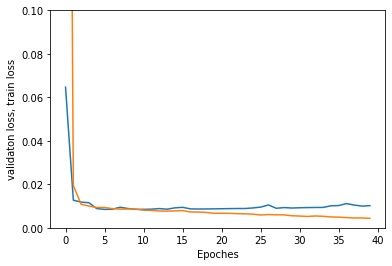

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.xlabel('Epoches')
plt.ylabel('validaton loss, train loss')
plt.plot(valid_loss)
plt.plot(train_loss)
plt.ylim(0,0.1)
plt.show()

In [ ]:
Y_pred = net.predict(X_test)
print(Y_pred)

[[2.8929906]
 [2.9101434]
 [2.9252632]
 [2.9689314]
 [2.9912457]
 [2.9224234]
 [2.9225428]
 [2.8018477]
 [2.8965876]
 [2.9407237]
 [2.9833806]
 [2.8710005]
 [2.8294053]
 [2.8361926]
 [2.874001 ]
 [2.9421048]
 [2.9551039]
 [2.8225012]
 [2.865411 ]
 [2.9857726]
 [2.9761233]
 [2.9006352]
 [2.8785346]
 [2.834069 ]
 [2.886226 ]
 [2.8718808]
 [2.9530675]
 [2.7994897]
 [2.955832 ]
 [2.9618857]
 [3.005693 ]
 [2.8855278]
 [2.8918138]
 [2.811827 ]
 [2.8491473]
 [2.9693453]
 [2.8180628]
 [2.886995 ]
 [2.9648807]
 [2.9637403]
 [2.9256968]
 [2.9441562]
 [2.8449738]
 [2.869982 ]
 [2.970408 ]
 [2.9836752]
 [2.8596275]
 [2.95287  ]
 [2.7721784]
 [2.9271302]
 [2.944487 ]
 [3.0177596]
 [2.8548024]
 [2.9419591]
 [3.0006557]
 [2.8259103]
 [2.8313057]
 [2.8505037]
 [2.811112 ]
 [2.7925081]
 [2.8521266]
 [2.9613123]
 [2.940078 ]
 [2.8788729]
 [2.9014542]
 [2.8638837]
 [2.9704802]
 [2.9659438]
 [2.9693003]
 [2.875094 ]
 [2.9624517]
 [3.0336976]
 [2.9466217]
 [2.9661324]
 [2.9346633]
 [2.9288354]
 [2.85618  ]

In [ ]:
len(Y_test)

562

In [ ]:
Y_pred

array([[2.8929906],
       [2.9101434],
       [2.9252632],
       [2.9689314],
       [2.9912457],
       [2.9224234],
       [2.9225428],
       [2.8018477],
       [2.8965876],
       [2.9407237],
       [2.9833806],
       [2.8710005],
       [2.8294053],
       [2.8361926],
       [2.874001 ],
       [2.9421048],
       [2.9551039],
       [2.8225012],
       [2.865411 ],
       [2.9857726],
       [2.9761233],
       [2.9006352],
       [2.8785346],
       [2.834069 ],
       [2.886226 ],
       [2.8718808],
       [2.9530675],
       [2.7994897],
       [2.955832 ],
       [2.9618857],
       [3.005693 ],
       [2.8855278],
       [2.8918138],
       [2.811827 ],
       [2.8491473],
       [2.9693453],
       [2.8180628],
       [2.886995 ],
       [2.9648807],
       [2.9637403],
       [2.9256968],
       [2.9441562],
       [2.8449738],
       [2.869982 ],
       [2.970408 ],
       [2.9836752],
       [2.8596275],
       [2.95287  ],
       [2.7721784],
       [2.9271302],


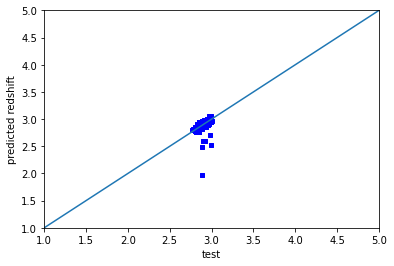

In [ ]:
#labels_norm = (Y - label_mean)/label_std

#Z = Y_pred*label_std+label_mean
#y = Y_test*label_std+label_mean

x1=np.linspace(0,7,9)
y1=x1
fig = plt.figure()
ax1 = fig.add_subplot(111)
#ax1.scatter(y, Z, s=10, c='b', marker="s")
ax1.scatter(Y_test, Y_pred, s=10, c='b', marker="s")
plt.plot(x1,y1)
plt.xlabel('test')
plt.ylabel('predicted redshift')
plt.xlim(1,5)
plt.ylim(1,5)
plt.show()

In [ ]:
Y_pred

array([[2.8929906],
       [2.9101434],
       [2.9252632],
       [2.9689314],
       [2.9912457],
       [2.9224234],
       [2.9225428],
       [2.8018477],
       [2.8965876],
       [2.9407237],
       [2.9833806],
       [2.8710005],
       [2.8294053],
       [2.8361926],
       [2.874001 ],
       [2.9421048],
       [2.9551039],
       [2.8225012],
       [2.865411 ],
       [2.9857726],
       [2.9761233],
       [2.9006352],
       [2.8785346],
       [2.834069 ],
       [2.886226 ],
       [2.8718808],
       [2.9530675],
       [2.7994897],
       [2.955832 ],
       [2.9618857],
       [3.005693 ],
       [2.8855278],
       [2.8918138],
       [2.811827 ],
       [2.8491473],
       [2.9693453],
       [2.8180628],
       [2.886995 ],
       [2.9648807],
       [2.9637403],
       [2.9256968],
       [2.9441562],
       [2.8449738],
       [2.869982 ],
       [2.970408 ],
       [2.9836752],
       [2.8596275],
       [2.95287  ],
       [2.7721784],
       [2.9271302],


In [ ]:
Y_test.numpy()

array([[2.8565593],
       [2.9335954],
       [2.9338825],
       [2.967439 ],
       [2.953008 ],
       [2.885975 ],
       [2.9307947],
       [2.8025377],
       [2.8743205],
       [2.915318 ],
       [2.971669 ],
       [2.896601 ],
       [2.8097625],
       [2.8398767],
       [2.8838997],
       [2.9205785],
       [2.9764967],
       [2.8236387],
       [2.8690975],
       [2.9532096],
       [2.9797027],
       [2.889285 ],
       [2.8263037],
       [2.8418567],
       [2.8551729],
       [2.899128 ],
       [2.927842 ],
       [2.8182333],
       [2.9452245],
       [2.9121692],
       [2.9968045],
       [2.8847418],
       [2.8909335],
       [2.8147926],
       [2.8474498],
       [2.9663248],
       [2.8026648],
       [2.8810327],
       [2.9733105],
       [3.0010383],
       [2.9538436],
       [2.9440365],
       [2.835129 ],
       [2.872585 ],
       [2.979817 ],
       [2.9713993],
       [2.8220944],
       [2.9618564],
       [2.8085544],
       [2.9296763],


In [ ]:
REL=300000*(Y_pred-Y_test.numpy())/(1+Y_test.numpy())
len(REL)

562

In [ ]:
#REL=300000*(Z-y.numpy())/(1+y.numpy())
#len(REL)

In [ ]:
abs(REL).mean()

2559.9405489324804

In [ ]:
for i in range(len(REL)):
    if ((abs(REL[i])<6000)):
        print(i, file=open("F.txt", "a"))

In [ ]:
file = open('F.txt', "r+")
file.truncate()
for i in range(len(REL)):
    if ((abs(REL[i])<6000)):
        print(i, file=open("F.txt", "a"))
        
with open("F.txt","r") as f:
    print(100*len(f.readlines())/len(REL))

97.50889679715303


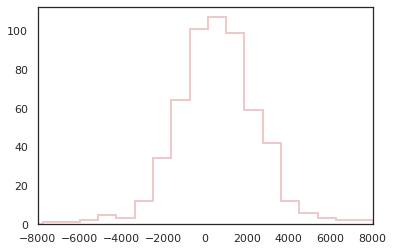

In [ ]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot
#pyplot.yscale('log')
data = REL


sns.set_style('white')

plt.hist(data, bins=500,histtype='step',alpha=0.3,edgecolor='r',linewidth=2)
#plt.hist(RE1, bins=1000,histtype='step',alpha=0.3,edgecolor='b',linewidth=2)

plt.xlim(-8000,8000)
#plt.ylim(0,7)
plt.show()